In [ ]:
!pip install replicate
!pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [ ]:
from google.colab import userdata
import os

#ambil api
api_token = userdata.get("api_token")
os.environ["REPLICATE_API_TOKEN"] = api_token

In [ ]:
from langchain_community.llms import Replicate

#kuchiyose model
model = Replicate(model="ibm-granite/granite-3.3-8b-instruct")

In [ ]:
# cek
response = model.invoke("halo granite, tolong jelaskan apa itu berita palsu (fake news) dalam 2 kalimat.")
print(response)


Berita palsu, juga dikenal sebagai fake news, adalah informasi yang disebarkan sebagai berita tetapi tidak berasal dari sumber yang terpercaya atau tidak dapat diberi kesan. Ini biasanya berisi ketidakbenaran, dramatisasi, atau konteks yang telah diubah dengan tujuan untuk menyebarkan ideologi tertentu atau menciptakan kerapuan.


In [ ]:
import pandas as biji

#memasukkan dataset fek dan tru, pake py, lalu on_bad_lines supaya baris rusak dilewati
fake_df = biji.read_csv("/content/Fake.csv", engine="python", on_bad_lines='skip')
true_df = biji.read_csv("/content/True.csv", engine="python", on_bad_lines='skip')

#reset samples & results
samples = []   # <- reset di sini
results = []   # <- reset di sini

#mengambil 3 cnth berita fek dan 3 berita rill
for i in range(3):
    samples.append(("FAKE", fake_df.iloc[i]["text"]))
    samples.append(("REAL", true_df.iloc[i]["text"]))

In [ ]:
from langchain_community.llms import Replicate

#parameter utk mengontrol granite
parameters = {
    "top_k": 20,                                  #20 kata teratas
    "top_p": 0.5,                                 #ngambil 50% probabiitas teratas
    "max_tokens": 256,                            #maks jawaban
    "min_tokens": 0,                              #min
    "random_seed": 42,                            #biar bisa direplikasi
    "repetition_penalty": 1.2,                    #penalti kalau ngulang
    "stopping_criteria": "length (256 tokens)",
    "stopping_sequence": None
}

#menyiapkan granite dari replicatee dgn parameter diatas
model = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct",
    model_kwargs=parameters
)


In [ ]:
for idx, (true_label, text) in enumerate(samples, start=1):
    #promptnya
    prompt = f"""
    You are a strict fake news detector.
    If the article does not explicitly cite a credible source (Reuters, BBC, New York Times, Associated Press, etc.), classify it as FAKE.
    Return JSON with label and reason.

    news:
    {text}
    """

    #panggil granite
    output = model.invoke(prompt)

    #print hasil di console
    print(f"\n--- Sample {idx} ---")
    print("Granite output:", output)

    #simpan ke ;list hasil
    results.append({
        "true_label": true_label,
        "granite_output": output
    })

#simpan hasil ke dataframe
df_results = biji.DataFrame(results)
print("\n=== Ringkasan Hasil Granite ===")
print(df_results)



--- Sample 1 ---
Granite output: {
  "label": "FAKE",
  "reason": "The article does not contain information from a credible news source. It is a collection of reactions and commentary on a tweet from Donald Trump's official Twitter account, which is not a credible news source. The original tweet itself is not analyzed for factual content, only its form and the reactions it elicited are discussed."
}

--- Sample 2 ---
Granite output: {
  "label": "NOT_FAKE",
  "reason": "The article is from Reuters, a credible news source, and it explicitly cites its source in the first line: 'WASHINGTON (Reuters) -'. The article discusses political developments in the U.S. Congress, including statements from Representatives Mark Meadows and Joseph Crowley, as well as House Speaker Paul Ryan, with clear attribution and context."
}

--- Sample 3 ---
Granite output: {
  "label": "NOT_FAKE",
  "reason": "The article explicitly cites credible sources, including the New York Times, Australian officials, and

In [ ]:
import json

#parsing hasil granite (dari json string ke kolom dataframe)
df_results["predicted_label"] = df_results["granite_output"].apply(
    lambda x: json.loads(x)["label"] if isinstance(x, str) else None
)

df_results["reason"] = df_results["granite_output"].apply(
    lambda x: json.loads(x)["reason"] if isinstance(x, str) else None
)

#lihat hasil parsing
print("\n=== Hasil Setelah Parsing ===")
print(df_results[["true_label", "predicted_label", "reason"]])

#hitung akurasi sederhana granite dgn data kaggle
accuracy = (df_results["true_label"] == df_results["predicted_label"]).mean()
print(f"\nAccuracy Granite vs Dataset Kaggle: {accuracy:.2f}")



=== Hasil Setelah Parsing ===
  true_label predicted_label  \
0       FAKE            FAKE   
1       REAL        NOT_FAKE   
2       FAKE        NOT_FAKE   
3       REAL        NOT FAKE   
4       FAKE            FAKE   
5       REAL        NOT_FAKE   

                                              reason  
0  The article does not contain information from ...  
1  The article is from Reuters, a credible news s...  
2  The article explicitly cites credible sources,...  
3  The article explicitly cites Reuters as its so...  
4  The article does not explicitly cite any credi...  
5  The article explicitly cites credible sources,...  

Accuracy Granite vs Dataset Kaggle: 0.33


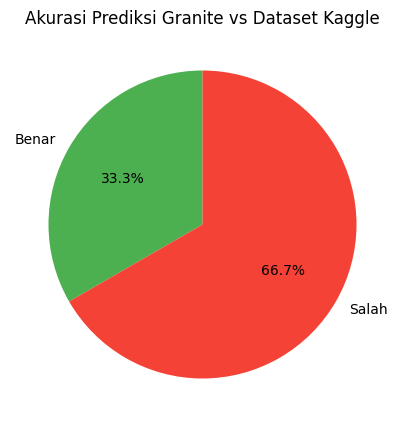

In [19]:
import matplotlib.pyplot as plt

# Hitung jumlah benar/salah
correct = (df_results['true_label'] == df_results['predicted_label']).sum()
wrong = len(df_results) - correct

# Pie chart
plt.figure(figsize=(5,5))
plt.pie([correct, wrong], labels=["Benar", "Salah"], autopct="%1.1f%%", startangle=90, colors=["#4CAF50","#F44336"])
plt.title("Akurasi Prediksi Granite vs Dataset Kaggle")
plt.show()
